# T5-NusaX-Machine-Translation

Indonesia have more than 17,000 islands, 360 ethnic groups, and 840 regional languages, Indonesia faces unique challenges in communication and socialization between its people. Moreover, without using it, our language can potentially become extinct.

This project aims to bridge this communication gap and increase the frequency of local language usage by creating a translation engine that can facilitate daily interactions.



## Install Import Dependencies

### Install

In [1]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate
!pip install evaluate
!pip install scikit-learn
!pip install bert-score
!pip install sacrebleu
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.9 MB/s eta 0:00:0

### Import

In [2]:
import torch
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sentencepiece
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from wordcloud import WordCloud
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_dataset, load_metric
from sacrebleu.metrics import BLEU, CHRF, TER
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score

from datasets import Dataset as DatasetHF
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm


### Install Bleurt for Metrics Evaluation

In [3]:
!pip install git+https://github.com/google-research/bleurt.git

  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-vrcua1yc
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/bleurt.git /tmp/pip-req-build-vrcua1yc
  Resolved https://github.com/google-research/bleurt.git to commit cebe7e6f996b40910cfaa520a63db47807e3bf5c
  Preparing metadata (setup.py) ... done
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456765 sha256=6989211c6d5aee4c0b85f4b4f0696d2d421b84bcc066fafc5d689445a51af90b
  Stored in directory: /tmp/pip-ephem-wheel-cache-8su5llpq/wheels/64/f4/2c/509a6c31b8ebde891a81029fd94f199b1b92f0e7cfc20d417a
Successfully built BLEURT


## Devine the Translation Tasks


First you can devine the specific translation from what languages that available in NusaX:

- ace: acehnese,
- ban: balinese,
- bjn: banjarese,
- bug: buginese,
- eng: english,
- ind: indonesian,
- jav: javanese,
- mad: madurese,
- min: minangkabau,
- nij: ngaju,
- sun: sundanese,
- bbc: toba_batak,

In [4]:
languages = [
    {
        'code': 'ace',
        'name': 'Acehnese'
    },
    {
        'code': 'ban',
        'name': 'Balinese'
    },
    {
        'code': 'bjn',
        'name': 'Banjarese',
    },
    {
        'code': 'bug',
        'name': 'Buginese',
    },
    {
        'code': 'eng',
        'name': 'English',
    },
    {
        'code': 'ind',
        'name': 'Indonesian',
    },
    {
        'code': 'jav',
        'name': 'Javanese',
    },
    {
        'code': 'mad',
        'name': 'Madurese',
    },
    {
        'code': 'min',
        'name': 'Minangkabau',
    },
    {
        'code': 'nij',
        'name': 'Ngaju'
    },
    {
        'code': 'sun',
        'name': 'Sundanese',
    },
    {
        'code': 'bbc',
        'name': 'Toba_Batak'
    },
]

source = 'sun'
target = 'ind'
source_name = next(item['name'] for item in languages if item['code'] == source)
target_name = next(item['name'] for item in languages if item['code'] == target)

prefix = f'Translate {source_name} to {target_name} : '

print(f"""
    Source: {source}
    Target: {target}
    Prefix: {prefix}
""")


    Source: sun
    Target: ind
    Prefix: Translate Sundanese to Indonesian :    



## Load Datasets

After specified the translation task you can start loading the datasets or you also can run all the cell.

In [5]:
print(f"""
    Source: {source}
    Target: {target}
    Prefix: {prefix}
""")

nusax_full = load_dataset("indonlp/NusaX-MT")
nusax = load_dataset("indonlp/NusaX-MT", name=f'{source}-{target}')

display(nusax_full)
display(nusax)


    Source: sun
    Target: ind
    Prefix: Translate Sundanese to Indonesian :    



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1454: FutureWarning: The repository for indonlp/NusaX-MT contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/indonlp/NusaX-MT
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnin

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1454: FutureWarning: The repository for indonlp/NusaX-MT contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/indonlp/NusaX-MT
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 66000
    })
    validation: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 13200
    })
    test: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 52800
    })
})

DatasetDict({
    train: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 100
    })
    test: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 400
    })
})

## EDA

Before using the datasets we should do some Exploratory to gain more information about the datasets

#### Convert Datasets HuggingFace into Pandas Dataframe

Before explore it we need to convert the datasets into pandas/dataframe type cause the datasets was in huggingface format

In [6]:
nusax_df_train = nusax['train'].to_pandas()
nusax_df_test = nusax['test'].to_pandas()
nusax_df_valid = nusax['validation'].to_pandas()

display(nusax_df_train)
print('#'*100)
display(nusax_df_test)
print('#'*100)
display(nusax_df_valid)

,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Nikmati angsuran 0% dugi ka 12 bulan kanggo me...,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,sun,ind
1,1,Kue anu disajikeun ngajantenkeun kuring nostal...,Kue-kue yang disajikan bikin saya bernostalgia...,sun,ind
2,2,Ibu kantos ngadamel di grab indonesia,Ibu pernah bekerja di grab indonesia,sun,ind
3,3,Pang resepna tuang beubeurangan di dieu hayam ...,Paling suka banget makan siang di sini ayam sa...,sun,ind
4,4,Palayanan beus DAMRI sae pisan,Pelayanan bus DAMRI sangat baik,sun,ind
...,...,...,...,...,...
495,495,Si A nyarita tong kosong heuras bunyina bicara...,Si A omongnya tong kosong nyaring bunyinya bic...,sun,ind
496,496,Sambelna moal aya di tempat nu sanes. Rasa tar...,Sambalnya tidak akan ada di tempat lain. Rasa ...,sun,ind
497,497,"Numutkeun abdi steakna cekap raos, mung leuwih...","Menurut saya steaknya cukup enak, hanya lebih ...",sun,ind
498,498,Dijaganya gus tuangeunna nuju usumna ayeuna ma...,Dijaga ya makannya gus emang lagi musimnya sek...,sun,ind


####################################################################################################


,id,text_1,text_2,text_1_lang,text_2_lang
0,0,"Caket ti hotel abdi ngendong, ngan ditempuh ku...","Dekat dengan hotel saya menginap, hanya ditemp...",sun,ind
1,1,"Muhun leureus , anjeunna nuju jaga warung.","Iya benar, dia sedang jaga warung.",sun,ind
2,2,Kangkungna lumayan mung kepiting saos padangna...,Kangkungnya lumayan tapi kepiting saus padangn...,sun,ind
3,3,Lokasi di Braga City Walk anu sagedong sareng ...,Bertempat di braga city walk yang satu gedung ...,sun,ind
4,4,Gianyar nampi bantosan sosial 2018 mangrup rp ...,Gianyar terima bantuan sosial 2018 sebesar rp ...,sun,ind
...,...,...,...,...,...
395,395,Kuring geus mindeng datang ngarasakeun kadahar...,Saya sudah sering kali datang menikmati makana...,sun,ind
396,396,Seueur jalmi kirang reseup berobat ka dokter. ...,Banyak orang yang kurang suka untuk berobat ke...,sun,ind
397,397,"Palayananna sae, tempat parkirna lega, kebon s...","Pelayanan baik, tempat parkir cukup luas, kebu...",sun,ind
398,398,"Demi naon wae tes cpns ngajieun macet, sialann...","Demi apa pun tes cpns bikin macet, sialannnnnnn",sun,ind


####################################################################################################


,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Upami anjeun ngagaduhan patarosan deui hoyong ...,Jika ada pertanyaan lebih lanjut yang ingin ka...,sun,ind
1,1,Karaosna pangaos kaki lima jeung rasana oge he...,Rasanya sih kok harga kaki lima dan rasanya ya...,sun,ind
2,2,"Sahenteuna cek pesen abdi, aya masalah pajeuli...","Minimal cek pesan saya, ada problem yang rumit...",sun,ind
3,3,Baheula restoran ieu nyaeta karesepan abdi ku ...,Dulu restoran ini merupakan favorit saya karen...,sun,ind
4,4,Nyaeta resto vintage nu pangaosna kahontal. Pa...,Merupakan resto vintage dengan harga yang cuku...,sun,ind
...,...,...,...,...,...
95,95,Mohon informasikeun atm mana wae di semarang n...,Mohon informasikan atm mana saja di semarang y...,sun,ind
96,96,Rerencangan nyarankeun tempat ieu kusabab rasa...,Teman merekomendasikan tempat ini karena rasa ...,sun,ind
97,97,"Mimiti kuring kadieu nganggap enteng, sawaktos...","Pertama ke sini saya under estimate, pas waktu...",sun,ind
98,98,Tempatna nyenengkeun nya kanggo nu atos berkul...,Tempatnya menyenangkan baik untuk yang sudah b...,sun,ind


### Merge Splited Datasets

after convert the datasets into dataframe we need to merge/concat the splitted dataframe, so we can analys the data easly.

In [7]:
nusax_df_concated = pd.concat(
    [
        nusax_df_train,
        nusax_df_test,
        nusax_df_valid
    ],
    axis=0,
    ignore_index=True
    )

display(nusax_df_concated)

,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Nikmati angsuran 0% dugi ka 12 bulan kanggo me...,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,sun,ind
1,1,Kue anu disajikeun ngajantenkeun kuring nostal...,Kue-kue yang disajikan bikin saya bernostalgia...,sun,ind
2,2,Ibu kantos ngadamel di grab indonesia,Ibu pernah bekerja di grab indonesia,sun,ind
3,3,Pang resepna tuang beubeurangan di dieu hayam ...,Paling suka banget makan siang di sini ayam sa...,sun,ind
4,4,Palayanan beus DAMRI sae pisan,Pelayanan bus DAMRI sangat baik,sun,ind
...,...,...,...,...,...
995,95,Mohon informasikeun atm mana wae di semarang n...,Mohon informasikan atm mana saja di semarang y...,sun,ind
996,96,Rerencangan nyarankeun tempat ieu kusabab rasa...,Teman merekomendasikan tempat ini karena rasa ...,sun,ind
997,97,"Mimiti kuring kadieu nganggap enteng, sawaktos...","Pertama ke sini saya under estimate, pas waktu...",sun,ind
998,98,Tempatna nyenengkeun nya kanggo nu atos berkul...,Tempatnya menyenangkan baik untuk yang sudah b...,sun,ind


### Analys and Visualize

First the easiest way is to check the sentence length from the each languages in the datasets. We can use apply and lambda function to get the length, After that let see the most common words in each languaes using Counter From Collections Library. And After that we can also visualize it using Matplotlib and Seaborn

In [8]:
# Function for get 10 most common words
def get_most_common_words(series, n_most_common=10):
    counter = Counter()
    for sentence in series:
        counter.update(sentence.lower().split())
    return counter.most_common(n_most_common)

# Function to get n-gram words
def generate_ngrams(text, n):
    words = text.split()
    ngrams = zip(*[words[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]


# Get Texts length
nusax_df_concated['text_1_length'] = nusax_df_concated['text_1'].apply(lambda x: len(x.split()))
nusax_df_concated['text_2_length'] = nusax_df_concated['text_2'].apply(lambda x: len(x.split()))

# Mendapatkan 10 kata teratas
top_source_words = get_most_common_words(nusax_df_concated['text_1'], 10)
top_target_words = get_most_common_words(nusax_df_concated['text_2'], 10)

# Membuat dataframe untuk visualisasi
df_vis_source = pd.DataFrame(top_source_words, columns=['Word', 'Frequency'])
df_vis_target = pd.DataFrame(top_target_words, columns=['Word', 'Frequency'])

# Get bigrams from source language
source_bigrams = generate_ngrams(" ".join(nusax_df_concated['text_1']), n=2)
# Get bigrams from target language
target_bigrams = generate_ngrams(" ".join(nusax_df_concated['text_2']), n=2)

display(nusax_df_concated.describe())
display(f"Top 10 {source_name} words : ", top_source_words)
display(f"Top 10 {target_name} words :", top_target_words)
display(f"Top 10 {source_name} Bigrams : ", Counter(source_bigrams).most_common(10))
display(f"Top 10 {target_name} Bigrams :", Counter(target_bigrams).most_common(10))

,text_1_length,text_2_length
count,1000.000000,1000.000000
mean,23.098000,23.117000
std,14.290298,14.411419
min,1.000000,4.000000
25%,12.000000,12.000000
50%,19.000000,19.000000
75%,31.000000,31.000000
max,76.000000,77.000000


'Top 10 Sundanese words : '

[('nu', 615),
 ('sareng', 542),
 ('di', 457),
 ('teu', 375),
 ('abdi', 314),
 ('ka', 247),
 ('aya', 216),
 ('anu', 214),
 ('kanggo', 198),
 ('ku', 192)]

'Top 10 Indonesian words :'

[('yang', 727),
 ('di', 545),
 ('dan', 541),
 ('tidak', 401),
 ('saya', 357),
 ('dengan', 299),
 ('untuk', 249),
 ('makan', 212),
 ('ini', 204),
 ('ke', 200)]

'Top 10 Sundanese Bigrams : '

[('di dieu', 40),
 ('tuang di', 37),
 ('teu aya', 37),
 ('ka dieu', 27),
 ('sumping ka', 27),
 ('tempat ieu', 24),
 ('tuangeun nu', 24),
 ('teu tiasa', 24),
 ('di tempat', 23),
 ('di dieu.', 21)]

'Top 10 Indonesian Bigrams :'

[('makan di', 44),
 ('di sini', 39),
 ('makanan yang', 33),
 ('tidak ada', 31),
 ('ke sini', 30),
 ('tidak terlalu', 30),
 ('enak dan', 29),
 ('tempat ini', 28),
 ('yang sangat', 27),
 ('di tempat', 25)]

#### Visualize

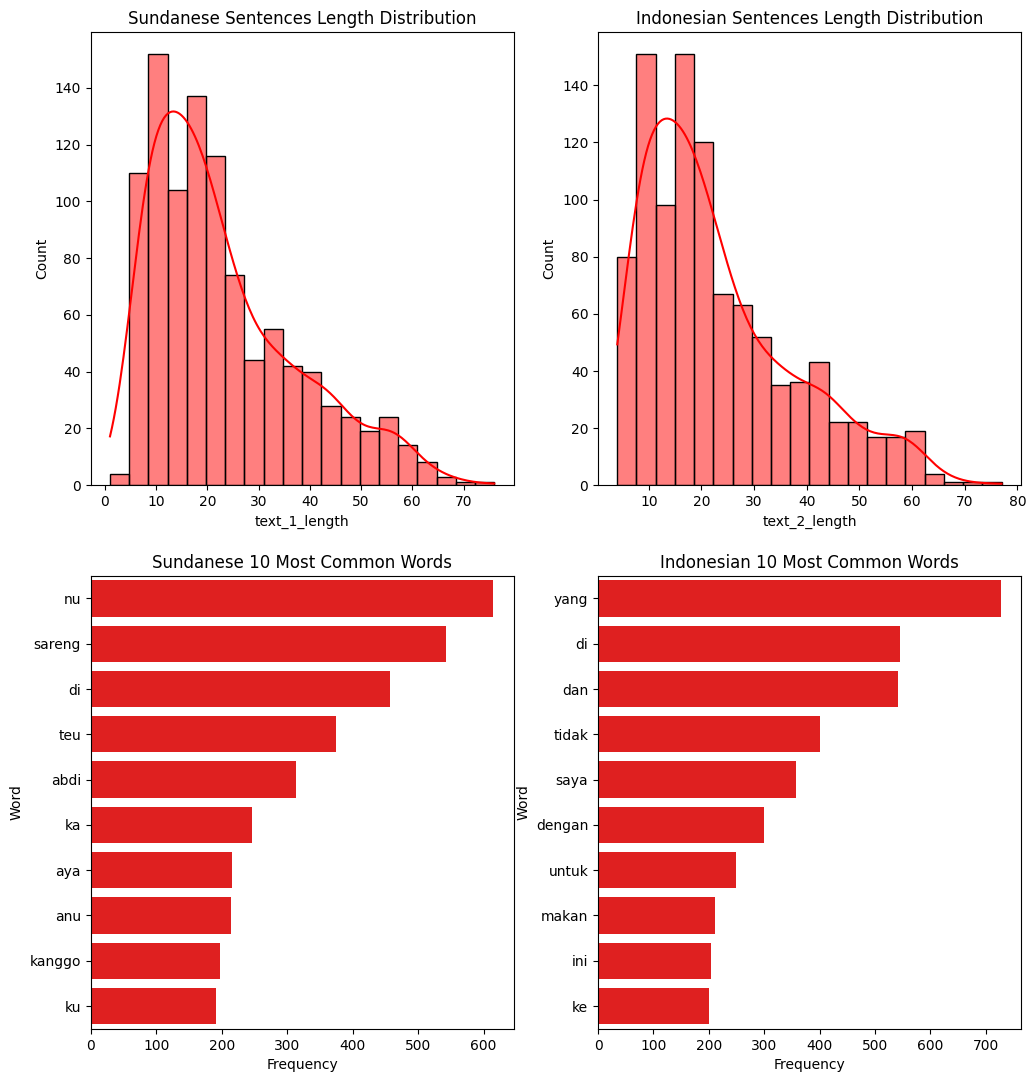

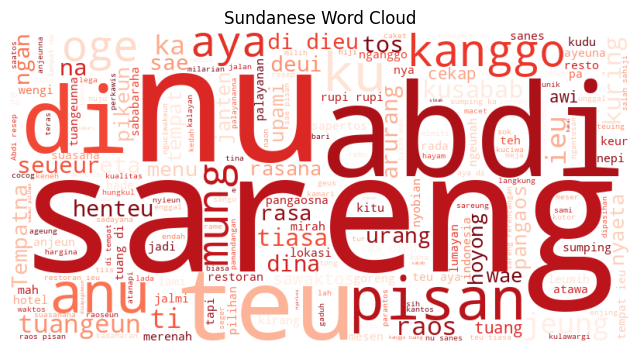

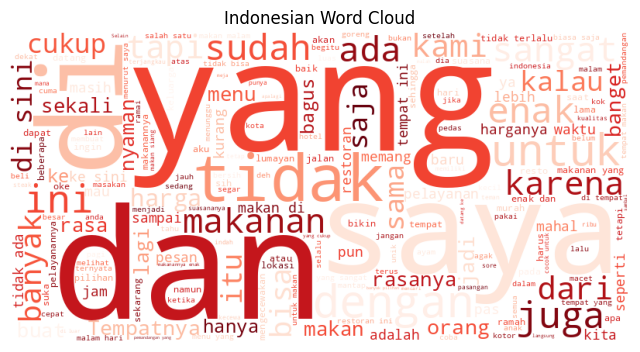

In [9]:
main_color = 'red'

# Dsitribution
plt.figure(figsize=(12, 20))
plt.subplot(3,2,1)
sns.histplot(nusax_df_concated['text_1_length'], kde=True, color=main_color)
plt.title(f'{source_name} Sentences Length Distribution')

plt.subplot(3,2,2)
sns.histplot(nusax_df_concated['text_2_length'], kde=True, color=main_color)
plt.title(f'{target_name} Sentences Length Distribution')

# Most Common
plt.subplot(3,2,3)
sns.barplot(x='Frequency', y='Word', data=df_vis_source, color=main_color)
plt.title(f'{source_name} 10 Most Common Words')

plt.subplot(3,2,4)
sns.barplot(x='Frequency', y='Word', data=df_vis_target, color=main_color)
plt.title(f'{target_name} 10 Most Common Words')

plt.show()


# Word Clouds
def plot_word_cloud(text, title):
    colormap = 'Reds'
    wordcloud = WordCloud(width=800, height=400, background_color ='white', colormap=colormap).generate(" ".join(text))
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_word_cloud(nusax_df_concated['text_1'], f'{source_name} Word Cloud')
plot_word_cloud(nusax_df_concated['text_2'], f'{target_name} Word Cloud')


## Datasets Preprocessing

Here we gonna splits the convert our dataframes into HuggingFace Datasets, and after that we splits the datasets become 80% train, 10% test, 10% validation, and concate the datasets. After that we vectorize and tokenize the datasets using tokenizer from T5.

First we need to convert the Dataframe into HF dataset again, and split the dataset manual

In [10]:
nusaX = DatasetHF.from_pandas(nusax_df_concated)

display(nusaX)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 1000
})

In [11]:
# Split the dataset into training, validation, and test sets
split_ratios = [0.8, 0.1, 0.1]  # 80% training, 10% validation, 10% test
split_names = ['train', 'validation', 'test']

splits_nusaX = nusaX.train_test_split(test_size=0.2)
train_dataset, valid_test_dataset = splits_nusaX['train'], splits_nusaX['test']

splits_nusaX = valid_test_dataset.train_test_split(test_size=0.5)
valid_dataset, test_dataset = splits_nusaX['train'], splits_nusaX['test']

display(train_dataset)
display(test_dataset)
display(valid_dataset)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 800
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 100
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 100
})

### Load Tokenizer

We also need to load tokenizer from T5-small/base/large

In [12]:
checkpoint = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
print(f"""
    Source: {source}
    Target: {target}
    Prefix: {prefix}
""")


    Source: sun
    Target: ind
    Prefix: Translate Sundanese to Indonesian :    



The preprocessing function you want to create needs to:

1. Prefix the input with a prompt so T5 knows this is a translation task. Some models capable of multiple NLP tasks require prompting for specific tasks.
2. Tokenize the input and target separately because you can't tokenize French text with a tokenizer pretrained on an English vocabulary.
3. Truncate sequences to be no longer than the maximum length set by the `max_length` parameter.

To apply the preprocessing function over the entire dataset, use 🤗 Datasets [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) method. You can speed up the `map` function by setting `batched=True` to process multiple elements of the dataset at once:



In [14]:
def preprocess_function(examples):

    inputs = [prefix + src for src in examples["text_1"]]
    targets = examples["text_2"]
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length", return_tensors="pt")

    # Prepare decoder_input_ids
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=256, truncation=True, padding="max_length", return_tensors="pt")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenized_nusax_train = train_dataset.map(preprocess_function, batched=True)
tokenized_nusax_test = test_dataset.map(preprocess_function, batched=True)
tokenized_nusax_valid = valid_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [15]:
display(tokenized_nusax_train['input_ids'][1])
display(tokenized_nusax_train['labels'][1])

[30355,
 15,
 3068,
 3768,
 15,
 7,
 15,
 12,
 9995,
 29,
 3,
 10,
 4540,
 4102,
 32,
 3,
 1468,
 8682,
 3,
 1258,
 10301,
 144,
 3,
 23,
 15,
 76,
 2662,
 40,
 10878,
 954,
 9113,
 2816,
 7,
 152,
 3,
 2905,
 3,
 17,
 15,
 115,
 23,
 107,
 3,
 17,
 23,
 6629,
 144,
 3,
 15414,
 9,
 5,
 1138,
 1259,
 19604,
 1227,
 1227,
 17,
 76,
 3,
 17,
 15,
 76,
 3,
 9,
 63,
 9,
 206,
 15142,
 7,
 23,
 138,
 206,
 2076,
 9,
 2341,
 399,
 1191,
 1618,
 152,
 3,
 17,
 15,
 115,
 23,
 107,
 3,
 1258,
 11119,
 6604,
 15,
 202,
 5,
 21063,
 29,
 9,
 14387,
 9,
 8036,
 15,
 5,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,

[597,
 17,
 1598,
 2285,
 2047,
 3,
 1050,
 10301,
 144,
 16,
 23,
 2662,
 40,
 15159,
 9,
 9965,
 144,
 954,
 9113,
 3,
 3768,
 2662,
 76,
 107,
 649,
 23,
 6629,
 144,
 3,
 15414,
 9,
 5,
 679,
 7,
 4624,
 9,
 77,
 63,
 9,
 1227,
 3,
 7,
 152,
 9,
 3,
 17,
 23,
 26,
 1639,
 3,
 9,
 26,
 9,
 3,
 3828,
 3,
 63,
 1468,
 15142,
 7,
 23,
 138,
 3,
 63,
 1468,
 140,
 51,
 3007,
 144,
 399,
 1191,
 1618,
 152,
 2662,
 76,
 107,
 3,
 449,
 11119,
 291,
 3304,
 5,
 21063,
 29,
 63,
 9,
 14387,
 9,
 3,
 7,
 9,
 1191,
 5,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 

## Model Development and Optimization

In [16]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

# model_path = "/content/drive/MyDrive/Models/T5-small-CC100-SU-JV-02"
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Now create a batch of examples using [DataCollatorForSeq2Seq](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorForSeq2Seq). It's more efficient to *dynamically pad* the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [17]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

Load the metrics, we using several mterics for this project

- Bleu: Bilingual evaluation understudy (BLEU) is an automatic evaluation metric used to measure the similarity of the hypothesis to the reference. BLEU measures both adequacy by looking at word precision and fluency by calculating n-gram precision for n =1,2,3,4.
- Meteor: The metric for evaluation of translation with explicit ordering (METEOR) is a metric designed to address the limitations of BLEU, which is a commonly used evaluation metric for machine translation.  For instance, BLEU does not consider the stems and synonyms of words, meaning that it does not match “running” and “runs”, as they are not counted as the same word in the n-gram matching process. Additionally, BLEU does not use recall, which results in short sentences being penalized.
- Bleurt: BLEURT is a pre-trained model with a BERT structure using multi-task loss on synthetic data of a large number of references. It is a sentence-level metric that learns prediction scores that explain the similarity between the hypothesis and references.
- BertScores: BERTscore compares the hypothesis and reference statements of the translator using features extracted by BERT that is trained for the masked language model and next sentence prediction. BERTscore uses token embeddings of the pre-trained BERT.

In [18]:
import evaluate

# Load metrics
sacrebleu_metric = evaluate.load("sacrebleu")
meteor_metric = evaluate.load("meteor")
bertscore_metric = evaluate.load("bertscore")
bluert_metrics = evaluate.load("bleurt", module_type="metric")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


compute metrics function for the metrics we gonna use Bleu, Meteor, Bleurt and BertScore to see the accuracy with various type metrics

In [19]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    # Flatten the list of lists for labels into a list of strings
    # labels = [label.strip() for sublist in labels for label in sublist]
    labels = [label.strip() for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    print(f"Decoded preds: {len(decoded_preds)}, Decoded labels: {len(decoded_labels)}")

    # Check if the number of predictions and references match
    if len(decoded_preds) != len(decoded_labels):
        raise ValueError(f"Number of predictions ({len(decoded_preds)}) does not match number of references ({len(decoded_labels)})")

    # Initialize result dictionary
    result = {}

    # Compute sacreBLEU
    bleu_result = sacrebleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    result["bleu"] = bleu_result["score"]

    # Compute METEOR
    meteor_result = meteor_metric.compute(predictions=decoded_preds, references=decoded_labels)
    result["meteor"] = meteor_result["meteor"]


    # Compute BLEURT
    bleurt_result = bluert_metrics.compute(predictions=decoded_preds, references=decoded_labels)
    # Choose a specific value to log (e.g., mean or median)
    result["Bleurt"] = round(np.mean(bleurt_result['scores']), 4)


    # Compute BERTScore
    bertscore_result = bertscore_metric.compute(predictions=decoded_preds, references=decoded_labels, lang="id")
    result["bertscore_precision"] = np.mean(bertscore_result["precision"])
    result["bertscore_recall"] = np.mean(bertscore_result["recall"])
    result["bertscore_f1"] = np.mean(bertscore_result["f1"])

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    # result = {k: round(v, 4) for k, v in result.items()}

    # Round specific metrics
    result["bleu"] = round(result["bleu"], 4)
    result["meteor"] = round(result["meteor"], 4)
    result["bertscore_precision"] = round(result["bertscore_precision"], 4)
    result["bertscore_recall"] = round(result["bertscore_recall"], 4)
    result["bertscore_f1"] = round(result["bertscore_f1"], 4)
    result["gen_len"] = round(result["gen_len"], 4)

    return result

In [20]:
training_args = Seq2SeqTrainingArguments(
    output_dir=f"{checkpoint}_NusaX_{source_name}_{target_name}_checkpoints",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=5,
    num_train_epochs=100,
    predict_with_generate=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_nusax_train,
    eval_dataset=tokenized_nusax_valid,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Meteor,Bleurt,Bertscore Precision,Bertscore Recall,Bertscore F1,Gen Len
1,No log,1.074452,0.000000,0.000000,-2.027400,0.000000,0.000000,0.000000,0.000000
2,No log,0.948172,0.000000,0.000000,-2.027400,0.000000,0.000000,0.000000,0.000000
3,No log,0.862977,0.000000,0.000000,-2.027400,0.000000,0.000000,0.000000,0.000000
4,No log,0.809324,0.000000,0.000000,-2.027400,0.000000,0.000000,0.000000,0.000000
5,No log,0.767496,0.000000,0.000000,-2.027400,0.000000,0.000000,0.000000,0.000000
6,No log,0.738692,0.000000,0.000000,-2.027400,0.000000,0.000000,0.000000,0.000000
7,No log,0.714536,0.000000,0.000000,-2.018600,0.006400,0.005900,0.006100,0.190000
8,No log,0.693518,0.000000,0.006100,-1.892900,0.089400,0.080700,0.084800,2.470000
9,No log,0.678014,0.000100,0.015700,-1.715100,0.207000,0.186900,0.196300,5.700000
10,1.392700,0.664106,0.000500,0.019000,-1.634200,0.253500,0.230700,0.241400,7.030000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 100, Decoded labels: 100


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


Decoded preds: 100, Decoded labels: 100


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100
Decoded preds: 100, Decoded labels: 100


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 100, Decoded labels: 100


TrainOutput(global_step=5000, training_loss=0.7221179260253906, metrics={'train_runtime': 2221.5928, 'train_samples_per_second': 36.01, 'train_steps_per_second': 2.251, 'total_flos': 5413672058880000.0, 'train_loss': 0.7221179260253906, 'epoch': 100.0})

Save the model to drive, or you aslo can push the model to HuggingFace if you want.

In [32]:
model_name = f"{checkpoint}_NusaX_{source_name}_{target_name}_model"
trainer.save_model(model_name)

In [22]:
# change the *...* with path to model
# !transformers-cli repo upload * path to model *

## Predict Evaluate

Great, now that you've finetuned a model, you can use it for inference!

Come up with some text you'd like to translate to another language. For T5, you need to prefix your input depending on the task you're working on. For translation from new languge to another new language, you should prefix your input as we when divined the translation task:

In [23]:
print(f"""
    Source: {source}
    Target: {target}
    Prefix: {prefix}
""")


    Source: sun
    Target: ind
    Prefix: Translate Sundanese to Indonesian :    



First we need to test the model with one sentence to make sure if it realy works

In [24]:
from transformers import pipeline

input = f"{prefix}Nikmati angsuran 0% dugi ka 12 bulan kanggo mesen tiket pasawat air asia nganggo kartu kiridit BNI!"

translator = pipeline("translation", model=model_name)
output = translator(input)

print(f"""
input  : {input}
output : {output}
""")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/__init__.py:1049: UserWarning: "translation" task was used, instead of "translation_XX_to_YY", defaulting to "translation_en_to_de"
  warnings.warn(



input  : Translate Sundanese to Indonesian : Nikmati angsuran 0% dugi ka 12 bulan kanggo mesen tiket pasawat air asia nganggo kartu kiridit BNI!
output : [{'translation_text': 'Nikmati angsuran 0% dugi ke 12 bulan kanggo mesen tiket pasawat air asia nganggo kartu kiridit BNI!'}]



if the test work we can continue to test the model with all the data test we was splitted before

In [28]:
def predict_evaluate(data):
    try:
        sources = data['text_1']
        targets = data['text_2']
        predictions = [translator(prefix + source)[0]['translation_text'] for source in sources]

        # Initialize lists to store results
        predicts, accuracies, bleus, meteors, bleurts, bertscore_precisions, bertscore_recalls, bertscore_f1s = [], [], [], [], [], [], [], []

        for prediction, target in zip(predictions, targets):
            predicts.append(prediction)

            # Calculate accuracy for each prediction
            accuracies.append(int(prediction == target))

            # Compute sacreBLEU
            bleu_result = sacrebleu_metric.compute(predictions=[prediction], references=[target])
            bleus.append(bleu_result["score"])

            # Compute METEOR
            meteor_result = meteor_metric.compute(predictions=[prediction], references=[target])
            meteors.append(meteor_result["meteor"])

            # Compute Bleurt
            bleurt_result = bluert_metrics.compute(predictions=[prediction], references=[target])
            bleurts.append(bleurt_result['scores'])

            # Compute BERTScore
            bertscore_result = bertscore_metric.compute(predictions=[prediction], references=[target], lang="id")
            bertscore_precisions.append(bertscore_result["precision"])
            bertscore_recalls.append(bertscore_result["recall"])
            bertscore_f1s.append(bertscore_result["f1"])

        # Return a dictionary with lists as values
        return {
            "input": data['text_1'],
            "predict": predicts,
            "target": targets,
            # "accuracy": accuracies,  # Now a list of accuracies
            "bleu": bleus,
            "meteor": meteors,
            "bleurt": bleurts,
            "bertscore_precision": bertscore_precisions,
            "bertscore_recall": bertscore_recalls,
            "bertscore_f1": bertscore_f1s
        }

    except Exception as e:
        print(f"Error during prediction or evaluation: {e}")
        return None

# Assuming test_dataset is correctly defined
data_test_predict_eval = test_dataset.map(predict_evaluate, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [29]:
predict_eval_df = data_test_predict_eval.to_pandas()

display(predict_eval_df.drop(
    [
        'text_1', 'text_2',
        'text_1_lang', 'text_2_lang',
        'text_1_length', 'text_2_length',
    ],
    axis=1)
)

,id,input,predict,target,bleu,meteor,bleurt,bertscore_precision,bertscore_recall,bertscore_f1
0,217,Panasaran hoyong nyobian hayam nu cekap kasoho...,Penasaran yang nyoba hayam yang cekap kasohor ...,Penasaran ingin dicoba ayam yang cukup terkena...,5.057492,0.177707,[-0.6214372515678406],[0.7076843976974487],[0.6791833639144897],[0.6931410431861877]
1,159,Salah sahiji mal ku konsep nu cekap unik. Seue...,Salah sahiji mal ku konsep yang cekap unik. Se...,Salah satu mal dengan konsep yang cukup unik. ...,7.535838,0.414250,[-0.06067723408341408],[0.7824770212173462],[0.8129618167877197],[0.7974281907081604]
2,75,Saatos ningali sakumna daerah dusun awi cocog ...,Saatos ningali sakumnya daerah dusun awi cocok...,Setelah melihat seluruh areanya dusun bambu co...,2.865096,0.196040,[-0.5078726410865784],[0.7132740020751953],[0.7250770926475525],[0.7191271185874939]
3,298,Lalajo sinetron ge geus bosen komo deui lalajo...,Lalajo sinetron yang komo deui lalajo isu wadu...,Nonton sinetron saja mulai bosan apalagi menon...,14.473711,0.374790,[-0.23829998075962067],[0.7816341519355774],[0.7949070334434509],[0.7882147431373596]
4,136,Kengingkeun hardisk ku harga promo pikeun ungg...,Indonesien : Kengingkan hardisk ku harga promo...,Dapatkan hardisk dengan harga promo untuk seti...,6.437165,0.403133,[-0.32501456141471863],[0.797834038734436],[0.8201084733009338],[0.8088179230690002]
...,...,...,...,...,...,...,...,...,...,...
95,150,Abdi nyobian suis butcher di suis butcher stia...,Saya nyobian suis butcher di suis butcher stia...,Saya mencoba suis butcher di selai di suis but...,27.935788,0.342069,[0.08749741315841675],[0.8509541153907776],[0.8025692105293274],[0.8260537385940552]
96,235,Lokasi na cekap tebih ti kota bandung sareng a...,Lokasi na cekap tebih tidak kota bandung dan a...,Lokasi agak jauh dari kota bandung dan sekaran...,7.125761,0.271303,[-0.5808888077735901],[0.6690928339958191],[0.6873264908790588],[0.6780871152877808]
97,210,Batagor kingsley raos pisan sareng dipikaresep...,Batagor kingsley dan dipikaresep ke keluarga d...,Batagor kingsley sangat lezat dan disukai oleh...,14.765613,0.380093,[-0.330858051776886],[0.7036134004592896],[0.7559573650360107],[0.7288467884063721]
98,139,"Dagoan weh, pasti dipasihan. Biasana ge maksim...","Dagoan weh, pasti dipasihan. Biasana ge maksim...","Ditunggu saja, pasti dikasih. Biasa maksimal s...",9.980099,0.315625,[-0.09562678635120392],[0.7970714569091797],[0.8011830449104309],[0.7991219758987427]


In [30]:
display(predict_eval_df.drop(
    [
        'text_1', 'text_2',
        'text_1_lang', 'text_2_lang',
        'text_1_length', 'text_2_length',
        # 'input',
        # 'bleu',
        # 'meteor',
        # 'bleurt',
        'bertscore_precision',
        'bertscore_recall',
        'bertscore_f1'
    ],
    axis=1)
)

,id,input,predict,target,bleu,meteor,bleurt
0,217,Panasaran hoyong nyobian hayam nu cekap kasoho...,Penasaran yang nyoba hayam yang cekap kasohor ...,Penasaran ingin dicoba ayam yang cukup terkena...,5.057492,0.177707,[-0.6214372515678406]
1,159,Salah sahiji mal ku konsep nu cekap unik. Seue...,Salah sahiji mal ku konsep yang cekap unik. Se...,Salah satu mal dengan konsep yang cukup unik. ...,7.535838,0.414250,[-0.06067723408341408]
2,75,Saatos ningali sakumna daerah dusun awi cocog ...,Saatos ningali sakumnya daerah dusun awi cocok...,Setelah melihat seluruh areanya dusun bambu co...,2.865096,0.196040,[-0.5078726410865784]
3,298,Lalajo sinetron ge geus bosen komo deui lalajo...,Lalajo sinetron yang komo deui lalajo isu wadu...,Nonton sinetron saja mulai bosan apalagi menon...,14.473711,0.374790,[-0.23829998075962067]
4,136,Kengingkeun hardisk ku harga promo pikeun ungg...,Indonesien : Kengingkan hardisk ku harga promo...,Dapatkan hardisk dengan harga promo untuk seti...,6.437165,0.403133,[-0.32501456141471863]
...,...,...,...,...,...,...,...
95,150,Abdi nyobian suis butcher di suis butcher stia...,Saya nyobian suis butcher di suis butcher stia...,Saya mencoba suis butcher di selai di suis but...,27.935788,0.342069,[0.08749741315841675]
96,235,Lokasi na cekap tebih ti kota bandung sareng a...,Lokasi na cekap tebih tidak kota bandung dan a...,Lokasi agak jauh dari kota bandung dan sekaran...,7.125761,0.271303,[-0.5808888077735901]
97,210,Batagor kingsley raos pisan sareng dipikaresep...,Batagor kingsley dan dipikaresep ke keluarga d...,Batagor kingsley sangat lezat dan disukai oleh...,14.765613,0.380093,[-0.330858051776886]
98,139,"Dagoan weh, pasti dipasihan. Biasana ge maksim...","Dagoan weh, pasti dipasihan. Biasana ge maksim...","Ditunggu saja, pasti dikasih. Biasa maksimal s...",9.980099,0.315625,[-0.09562678635120392]


In [31]:
display(predict_eval_df['bleu'].mean())
display(predict_eval_df['meteor'].mean())
display(predict_eval_df['bleurt'].mean())
display(predict_eval_df['bertscore_precision'].mean())
display(predict_eval_df['bertscore_recall'].mean())
display(predict_eval_df['bertscore_f1'].mean())

14.58751580844615

0.38445811240434835

array([-0.18675101])

array([0.78077078])

array([0.78379343])

array([0.78203854])

# Datasets
- https://huggingface.co/datasets/indonlp/NusaX-MT
- https://github.com/IndoNLP/nusax
- https://ar5iv.labs.arxiv.org/html/2205.15960

# References

- https://github.com/huggingface/transformers/tree/main/examples/pytorch/translation
- https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/translation.ipynb#scrollTo=X4cRE8IbIrIV
- https://huggingface.co/docs/transformers/tasks/translation
- https://huggingface.co/docs/transformers/model_doc/t5
- https://github.com/EliasK93/transformer-models-for-domain-specific-machine-translation
- https://huggingface.co/docs/transformers/model_doc/marian#old-style-multi-lingual-models
- https://www.mdpi.com/2227-7390/11/4/1006
- https://huggingface.co/spaces/evaluate-metric/bertscore#:~:text=Metric%20description,token%20in%20the%20reference%20sentence
- https://huggingface.co/spaces/evaluate-metric/bleurt